In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)        

In [12]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
data = pd.concat([train,test])

import matplotlib.pyplot as plt


data.columns
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


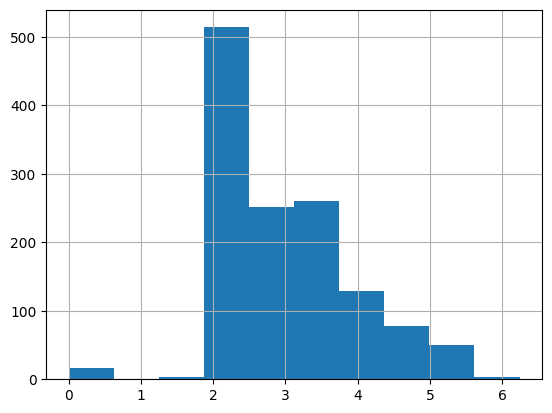

In [13]:

# Load relevant data
data['cabin_multiple'] = data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
data['cabin_adv'] = data.Cabin.apply(lambda x: str(x)[0])
data['numeric_ticket'] = data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
data['ticket_letters'] = data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)
data['name_title'] = data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Fix up data
data.Age = data.Age.fillna(train.Age.median())
data.Fare = data.Fare.fillna(train.Fare.median())
data.dropna(subset=['Embarked'],inplace = True)
data['norm_fare'] = np.log(data.Fare+1)
data['norm_fare'].hist()
data.Pclass = data.Pclass.astype(str)

dummies = pd.get_dummies(data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','name_title','train_test']])

# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
dummies[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(dummies[['Age','SibSp','Parch','norm_fare']])

dummies

X_test_scaled = dummies[dummies.train_test == 0].drop(['train_test'], axis =1)
X_train_scaled = dummies[dummies.train_test == 1].drop(['train_test'], axis =1)

y_train = data[data.train_test==1].Survived

In [14]:
# Naive Bayes
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

#cv = cross_val_score(GaussianNB(), X_train_scaled, y_train, cv=5)
#print(cv.mean)

voting_clf = VotingClassifier(estimators = [("NB", GaussianNB())], voting = 'soft') 
voting_clf.fit(X_train_scaled,y_train)

y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
submission = pd.DataFrame(data=submission)
submission.to_csv('submission.csv', index=False)

submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
